# electricity_market_player

> This module training optimizing and evaluation of RL agent on the electricity market environment.
using PPO with actions mask.

In [ ]:
#| default_exp electricity_market_player

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from abc import ABC

import matplotlib.pyplot as plt
import numpy as np
import optuna
import seaborn as sns

from sb3_contrib import MaskablePPO, QRDQN
from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy
from sb3_contrib.common.wrappers import ActionMasker
from sb3_contrib.common.maskable.evaluation import evaluate_policy as maskable_evaluate_policy
from scipy import stats
from stable_baselines3.common.base_class import BaseAlgorithm
from stable_baselines3.common.evaluation import evaluate_policy as non_maskable_evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from rliable import metrics, plot_utils, library as rly

from electricity_market.electricity_market_env import ElectricityMarketEnv


In [ ]:
#| export
TOTAL_TIMESTEPS = 10_000 # 100_000
N_EPISODES = 10
N_TRAILS = 10
N_JOBS = 7
seeds = [123456] #, 234567, 345678, 456789, 567890]
if TOTAL_TIMESTEPS % N_EPISODES != 0:
    raise ValueError("Total_timesteps must be a multiple of n_episodes")
frames = np.array(list(range(TOTAL_TIMESTEPS // N_EPISODES, TOTAL_TIMESTEPS + 1, TOTAL_TIMESTEPS // N_EPISODES)), dtype=int)

# Decided On granularity of 100 Wh
env_config = {
    "max_timestep": TOTAL_TIMESTEPS,
}
results = {}

In [ ]:
#| export
class Agent(ABC):
    def __init__(self):
        pass

    @classmethod
    def mask_fn(cls, env: ElectricityMarketEnv) -> np.ndarray:
        return env.action_masks()

    @classmethod
    def collect_episodes_rewards(
            cls,
            model: BaseAlgorithm | None,
            env: ElectricityMarketEnv,
            n_episodes: int = N_EPISODES,
            deterministic: bool = True,
            render: bool = False
    ) -> list[float]:
        raise NotImplementedError

    @classmethod
    def evaluate_policy(
            cls, hyperparameters: dict | None = None,
            n_episodes: int = N_EPISODES,
            render: bool = False
    ) -> np.array:
        raise NotImplementedError

    @classmethod
    def optimize_agent(cls, trial, n_episodes: int = N_EPISODES):
        raise NotImplementedError



In [ ]:
class MaskableRandomAgent(Agent):
    @classmethod
    def collect_episodes_rewards(
            cls,
            model: BaseAlgorithm,  # Unused for a random agent
            env: ElectricityMarketEnv,
            n_episodes: int = N_EPISODES,
            deterministic: bool = True,
            render: bool = False
    ) -> list[float]:
        episode_rewards = []

        for _ in range(n_episodes):
            obs, _ = env.reset()
            done = False
            total_reward = 0.0

            while not done:
                action_mask = env.action_masks()
                valid_actions = np.where(action_mask)[0]  # Get valid actions
                action = np.random.choice(valid_actions)  # Select random valid action

                obs, reward, done, truncated, _ = env.step(action)
                total_reward += reward
                if truncated:
                    break

            episode_rewards.append(total_reward)

        return episode_rewards

    @classmethod
    def evaluate_policy(
            cls,
            hyperparameters: dict | None = None,
            n_episodes: int = N_EPISODES,
            render: bool = False
    ) -> np.array:
        global seeds, frames, env_config

        all_rewards = []

        for seed in seeds:
            print(f"\nRunning random agent with seed {seed}...")
            env = ActionMasker(ElectricityMarketEnv(env_config, render_mode="human"), cls.mask_fn)

            seed_rewards = []

            for frame in frames:
                print(f"  Evaluating at {frame} timesteps...")
                rewards = cls.collect_episodes_rewards(None, env, n_episodes, deterministic=True, render=render)
                seed_rewards.append(rewards)

            seed_rewards = np.array(seed_rewards)  # Shape: (num_checkpoints, num_episodes)
            all_rewards.append(seed_rewards)

        all_rewards = np.array(all_rewards)  # Shape: (num_seeds, num_checkpoints, num_episodes)
        print("\nCollected Rewards (shape: seeds x checkpoints x episodes):\n", all_rewards)

        return all_rewards

    @classmethod
    def optimize_agent(cls, trial, n_episodes: int = N_EPISODES):
        raise NotImplementedError


In [ ]:
#| export
class MaskablePPOAgent(Agent):
    @classmethod
    def collect_episodes_rewards(
            cls,
            model: MaskablePPO,
            env: ElectricityMarketEnv,
            n_episodes: int = N_EPISODES,
            deterministic: bool = True,
            render: bool = False
    ) -> list[float]:
        episode_rewards, _ = maskable_evaluate_policy(
            model, env, deterministic=deterministic, use_masking=True,
            return_episode_rewards=True, n_eval_episodes=n_episodes, render=render
        )
        return episode_rewards

    @classmethod
    def evaluate_policy(
            cls,
            hyperparameters: dict | None = None,
            n_episodes: int = N_EPISODES,
            render: bool = False
    ) -> np.array:
        global seeds, frames, env_config

        if hyperparameters is None:
            hyperparameters = {}
        all_rewards = []

        for seed in seeds:
            print(f"\nRunning experiment with seed {seed}...")
            env = DummyVecEnv([
                lambda: Monitor(ActionMasker(ElectricityMarketEnv(env_config, render_mode="human"), cls.mask_fn))
            ])

            model = MaskablePPO(
                MaskableActorCriticPolicy,
                env,
                verbose=0,
                seed=seed,
                **hyperparameters
            )
            seed_rewards = []

            for frame in frames:
                model.learn(
                    total_timesteps=frame, use_masking=True, reset_num_timesteps=False
                )
                rewards = cls.collect_episodes_rewards(
                    model, env,
                    n_episodes=n_episodes, deterministic=True, render=render
                )
                seed_rewards.append(rewards)

            seed_rewards = np.array(seed_rewards)  # Shape: (num_checkpoints, num_episodes)
            all_rewards.append(seed_rewards)

        all_rewards = np.array(all_rewards)  # Shape: (num_seeds, num_checkpoints, num_episodes)
        print("\nCollected Rewards (shape: seeds x checkpoints x episodes):\n", all_rewards)
        return all_rewards

    @classmethod
    def optimize_agent(cls, trial, n_episodes: int = N_EPISODES):
        global seeds
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
        n_steps = trial.suggest_int('n_steps', 32, 1024, log=True)
        batch_size = trial.suggest_int('batch_size', 16, 256, log=True)
        gamma = trial.suggest_float('gamma', 0.9, 0.9999)
        gae_lambda = trial.suggest_float('gae_lambda', 0.8, 1.0)
        ent_coef = trial.suggest_float('ent_coef', 0.0, 0.02)
        vf_coef = trial.suggest_float('vf_coef', 0.1, 1.0)
        clip_range = trial.suggest_float('clip_range', 0.1, 0.3)
        max_grad_norm = trial.suggest_float('max_grad_norm', 0.1, 1.0)

        trial_seed_rewards = []

        for seed in seeds:
            env = DummyVecEnv([
                lambda: Monitor(ActionMasker(ElectricityMarketEnv(env_config, render_mode="human"), maskable_ppo_agent.mask_fn))
            ])

            model = MaskablePPO(
                MaskableActorCriticPolicy,
                env,
                learning_rate=learning_rate,
                n_steps=n_steps,
                batch_size=batch_size,
                gamma=gamma,
                gae_lambda=gae_lambda,
                ent_coef=ent_coef,
                vf_coef=vf_coef,
                clip_range=clip_range,
                max_grad_norm=max_grad_norm,
                verbose=0,
                seed=seed
            )

            model.learn(total_timesteps=TOTAL_TIMESTEPS, use_masking=True)
            episode_rewards = cls.collect_episodes_rewards(model, env, n_episodes=n_episodes, deterministic=True, render=False)

            seed_avg_reward = np.mean(episode_rewards)
            trial_seed_rewards.append(seed_avg_reward)
        aggregated_performance = stats.trim_mean(trial_seed_rewards, proportiontocut=0.25)

        return aggregated_performance



In [ ]:
#| export
class QRDQNAgent(Agent):
    @classmethod
    def collect_episodes_rewards(
            cls,
            model: QRDQN,
            env: ElectricityMarketEnv,
            n_episodes: int = N_EPISODES,
            deterministic: bool = True,
            render: bool = False
    ) -> list[float]:
        episode_rewards, _ = non_maskable_evaluate_policy(
            model, env, deterministic=deterministic,
            return_episode_rewards=True, n_eval_episodes=n_episodes, render=render
        )
        return episode_rewards

    @classmethod
    def evaluate_policy(
            cls,
            hyperparameters: dict | None = None,
            n_episodes: int = N_EPISODES,
            render: bool = False
    ) -> np.array:
        global seeds, frames, env_config

        if hyperparameters is None:
            hyperparameters = {}
        all_rewards = []

        for seed in seeds:
            print(f"\nRunning experiment with seed {seed}...")
            env = DummyVecEnv([
                lambda: Monitor(ElectricityMarketEnv(env_config, render_mode="human"))
            ])

            model = QRDQN(
                "MlpPolicy",
                env,
                verbose=0,
                seed=seed,
                **hyperparameters
            )
            seed_rewards = []

            for frame in frames:
                print(f"  Training for {frame} timesteps...")
                model.learn(total_timesteps=frame, reset_num_timesteps=False)

                rewards = cls.collect_episodes_rewards(
                    model, env,
                    n_episodes=n_episodes, deterministic=True, render=render
                )
                seed_rewards.append(rewards)

            seed_rewards = np.array(seed_rewards)  # Shape: (num_checkpoints, num_episodes)
            all_rewards.append(seed_rewards)

        all_rewards = np.array(all_rewards)  # Shape: (num_seeds, num_checkpoints, num_episodes)
        print("\nCollected Rewards (shape: seeds x checkpoints x episodes):\n", all_rewards)
        return all_rewards

    @classmethod
    def optimize_agent(cls, trial, n_episodes: int = N_EPISODES):
        global seeds

        # Hyperparameter tuning using Optuna
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
        batch_size = trial.suggest_int('batch_size', 16, 256, log=True)
        gamma = trial.suggest_float('gamma', 0.9, 0.9999)
        exploration_fraction = trial.suggest_float('exploration_fraction', 0.1, 0.5)
        exploration_final_eps = trial.suggest_float('exploration_final_eps', 0.01, 0.1)
        target_update_interval = trial.suggest_int('target_update_interval', 100, 10000, log=True)

        trial_seed_rewards = []

        for seed in seeds:
            env = DummyVecEnv([
                lambda: Monitor(ElectricityMarketEnv(env_config, render_mode="human"))
            ])

            model = QRDQN(
                "MlpPolicy",
                env,
                learning_rate=learning_rate,
                batch_size=batch_size,
                gamma=gamma,
                exploration_fraction=exploration_fraction,
                exploration_final_eps=exploration_final_eps,
                target_update_interval=target_update_interval,
                verbose=0,
                seed=seed
            )

            model.learn(total_timesteps=TOTAL_TIMESTEPS)
            episode_rewards = cls.collect_episodes_rewards(model, env, n_episodes=n_episodes, deterministic=True, render=False)

            seed_avg_reward = np.mean(episode_rewards)
            trial_seed_rewards.append(seed_avg_reward)

        # Trimmed mean to avoid outliers affecting optimization
        aggregated_performance = stats.trim_mean(trial_seed_rewards, proportiontocut=0.25)

        return aggregated_performance


In [ ]:
#| export
def plot_evaluation_results(evaluation_results: dict) -> None:
    global seeds, frames, env_config
    # Extract algorithm names (which are actually keys in the dictionary)
    algorithms = list(evaluation_results.keys())

    # Function to compute aggregate metrics (median, IQM, mean) for each checkpoint and seed
    def aggregate_func(x):
        return np.array([
            metrics.aggregate_median(x),
            metrics.aggregate_iqm(x),
            metrics.aggregate_mean(x),
        ])

    # For each algorithm, we need to apply aggregate_func to the data (which has the shape (num_seeds, num_checkpoints, num_episodes))
    def aggregate_over_checkpoints(evaluation_results):
        aggregated_results = {}
        for algorithm, results in evaluation_results.items():
            # results.shape is (num_seeds, num_checkpoints, num_episodes)
            # We aggregate across seeds and episodes for each checkpoint
            agg_results = np.array([aggregate_func(results[:, i, :]) for i in range(results.shape[1])])
            aggregated_results[algorithm] = agg_results
        return aggregated_results

    # Aggregate results across seeds and episodes
    aggregated_results = aggregate_over_checkpoints(evaluation_results)

    # Use rly to compute interval estimates
    aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
        aggregated_results, aggregate_func, reps=50000
    )

    # Plot aggregate metrics (Median, IQM, Mean)
    metric_names = ['Median', 'IQM', 'Mean']
    fig, axes = plot_utils.plot_interval_estimates(
        aggregate_scores,
        aggregate_score_cis,
        metric_names=metric_names,
        algorithms=algorithms,
        xlabel='Reward'
    )
    fig.set_size_inches(10, 5)
    plt.suptitle("Aggregate Metrics with 95% Stratified Bootstrap CIs", y=1.05, fontsize=16)
    plt.xticks(rotation=45, fontsize=12)
    plt.show()

    # =============================================================================
    # 2. Probability of Improvement (if comparing two algorithms)
    # =============================================================================
    if len(algorithms) == 2:
        alg1, alg2 = algorithms
        algorithm_pairs = {f"{alg1},{alg2}": (evaluation_results[alg1], evaluation_results[alg2])}

        average_probabilities, average_prob_cis = rly.get_interval_estimates(
            algorithm_pairs, metrics.probability_of_improvement, reps=2000
        )

        plot_utils.plot_probability_of_improvement(average_probabilities, average_prob_cis)
        plt.title(f"Probability of Improvement: {alg1} vs {alg2}", pad=20)
        plt.show()

    # =============================================================================
    # 3. Sample Efficiency Curve (using frames as defined in the evaluation function)
    # =============================================================================
    sample_efficiency_dict = {
        alg: results[:, :, :]
        for alg, results in evaluation_results.items() if len(results.shape) == 3
    }

    # Define the IQM function
    iqm_func = lambda scores: np.array([metrics.aggregate_iqm(scores[:, :, frame]) for frame in range(scores.shape[2])])

    # Compute IQM scores and confidence intervals using rly
    iqm_scores, iqm_cis = rly.get_interval_estimates(sample_efficiency_dict, iqm_func, reps=50000)
    # Plot the sample efficiency curve
    plot_utils.plot_sample_efficiency_curve(
        frames=frames + 1,  # Adjust frames if necessary
        point_estimates=iqm_scores,
        interval_estimates=iqm_cis,
        algorithms=sample_efficiency_dict.keys(),
        xlabel='Number of Frames',
        ylabel='IQM Reward'
    )
    plt.title("Sample Efficiency Curve")
    plt.show()


    # =============================================================================
    # 4. Performance Profiles (linear and non-linear scaling)
    # =============================================================================
    thresholds = np.linspace(0.0, 8.0, 81)
    score_distributions, score_distributions_cis = rly.create_performance_profile(
        evaluation_results, thresholds
    )

    # Plot performance profiles with linear scale
    fig, ax = plt.subplots(ncols=1, figsize=(7, 5))
    plot_utils.plot_performance_profiles(
        score_distributions,
        thresholds,
        performance_profile_cis=score_distributions_cis,
        colors=dict(zip(algorithms, sns.color_palette('colorblind'))),
        xlabel=r'Normalized Score $(\tau)$',
        ax=ax
    )
    plt.title("Performance Profiles (Linear Scale)")
    plt.show()

    # Plot performance profiles with non-linear scaling
    thresholds = np.logspace(-1, 0, num=50)
    fig, ax = plt.subplots(ncols=1, figsize=(7, 5))
    plot_utils.plot_performance_profiles(
        score_distributions,
        thresholds,
        performance_profile_cis=score_distributions_cis,
        use_non_linear_scaling=True,
        colors=dict(zip(algorithms, sns.color_palette('colorblind'))),
        xlabel=r'Normalized Score $(\tau)$',
        ax=ax
    )
    # ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    plt.title("Performance Profiles (Non-Linear Scaling)")
    plt.tight_layout()
    plt.show()

In [ ]:
#| export
qrdqn_agent = QRDQNAgent()
maskable_random_agent = MaskableRandomAgent()
maskable_ppo_agent = MaskablePPOAgent()

### Evaluation MaskableRandom on ElectricityMarketEnv


In [ ]:
#| export
results["MaskableRandomAgent"] = maskable_random_agent.evaluate_policy(hyperparameters=None, n_episodes=N_EPISODES, render=False)


Running random agent with seed 123456...
  Evaluating at 1000 timesteps...
  Evaluating at 2000 timesteps...
  Evaluating at 3000 timesteps...
  Evaluating at 4000 timesteps...
  Evaluating at 5000 timesteps...
  Evaluating at 6000 timesteps...
  Evaluating at 7000 timesteps...
  Evaluating at 8000 timesteps...
  Evaluating at 9000 timesteps...
  Evaluating at 10000 timesteps...

Collected Rewards (shape: seeds x checkpoints x episodes):
 [[[ 97.39391509  95.77681323  96.45417318 101.48065582  99.98770936
    99.85083639  93.38915784 104.78730983  97.18765272  96.61368065]
  [100.61823151  90.41789353  90.46521432  94.33032751 102.53234014
    94.97495745  96.06260584  97.31260537  97.17686434  98.3846164 ]
  [ 97.01797558  93.63922804  95.58828247  87.38078685  88.11017892
   104.94940942 103.44002879  94.98947902  97.72508082 100.43699639]
  [ 92.93091553 104.13381257  93.38421773  96.61498319  97.94096165
    91.32524598  92.78546755 101.54078304  96.5650628   90.92607957]
  [ 92.4

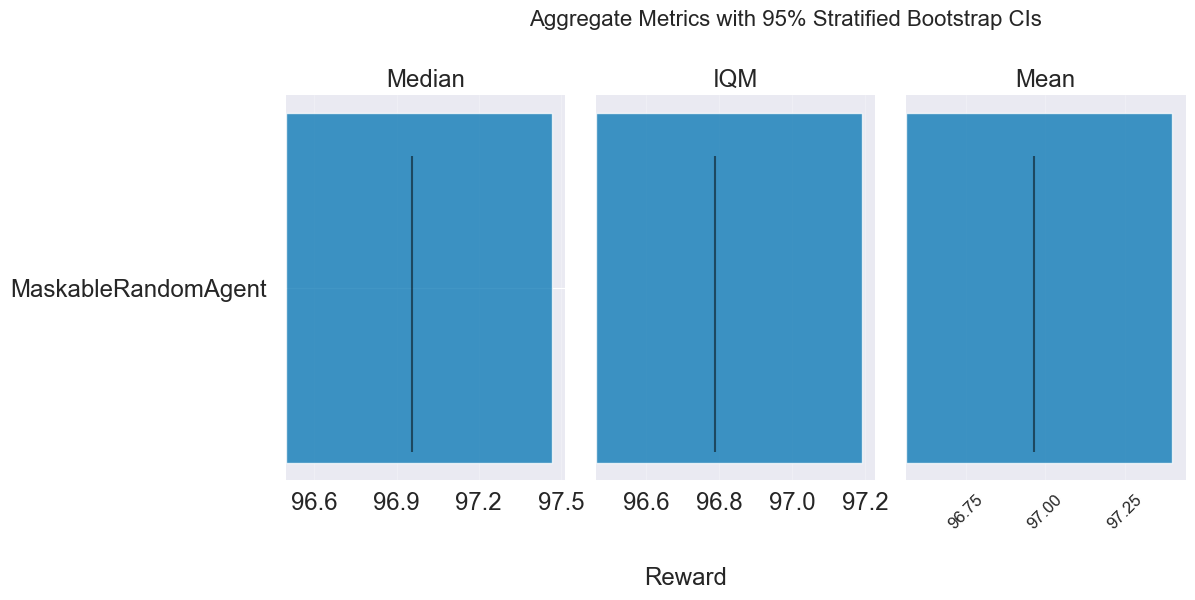

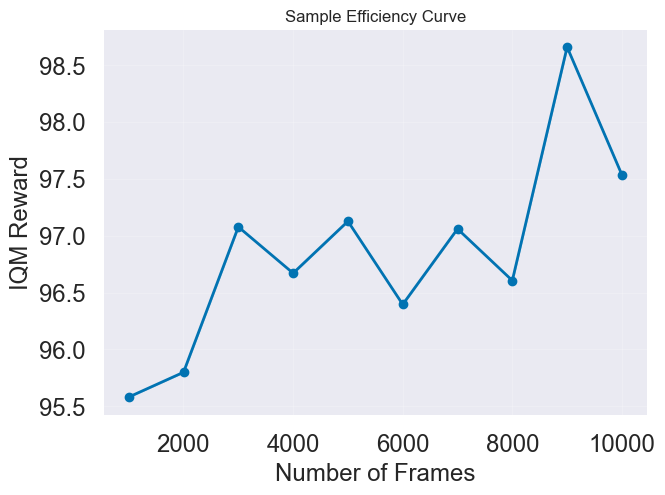

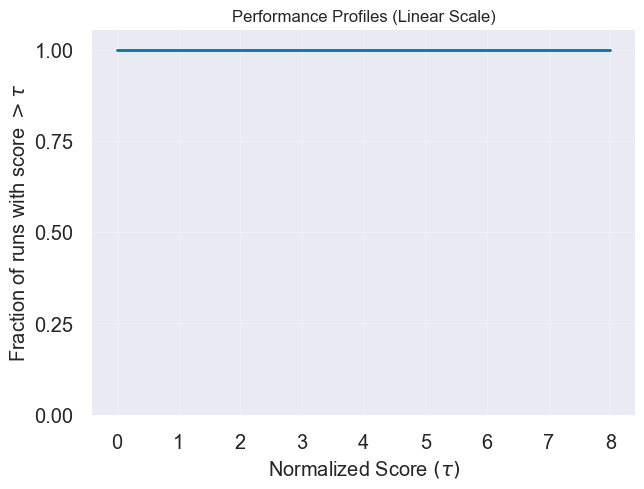

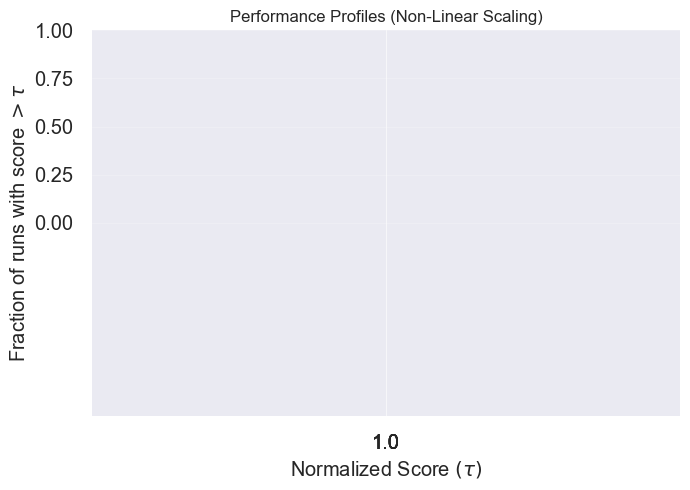

In [ ]:
#| export
plot_evaluation_results(results)

In [ ]:
    #| export
results["QRDQNAgent_Baseline"] = qrdqn_agent.evaluate_policy(hyperparameters=None, n_episodes=N_EPISODES, render=False)


Running experiment with seed 123456...
  Training for 1000 timesteps...
  Training for 2000 timesteps...
  Training for 3000 timesteps...
  Training for 4000 timesteps...
  Training for 5000 timesteps...
  Training for 6000 timesteps...
  Training for 7000 timesteps...
  Training for 8000 timesteps...
  Training for 9000 timesteps...
  Training for 10000 timesteps...

Collected Rewards (shape: seeds x checkpoints x episodes):
 [[[-10001.       -10001.       -10001.       -10001.       -10001.
   -10001.       -10001.       -10001.       -10001.       -10001.      ]
  [ -9508.240178  -9620.951663  -9583.802786  -9559.744764  -9462.987052
    -9610.775399  -9565.860218  -9538.302713  -9561.813898  -9516.84133 ]
  [ -3905.147283  -3938.045441  -3924.821946  -3953.674004  -3868.284817
    -3913.281272  -3968.709231  -3803.893775  -3899.148987  -4008.120296]
  [ -3067.409933  -3083.865176  -3051.909955  -3081.85783   -3039.72552
    -3143.923211  -3043.010742  -3068.58839   -2979.120846  -

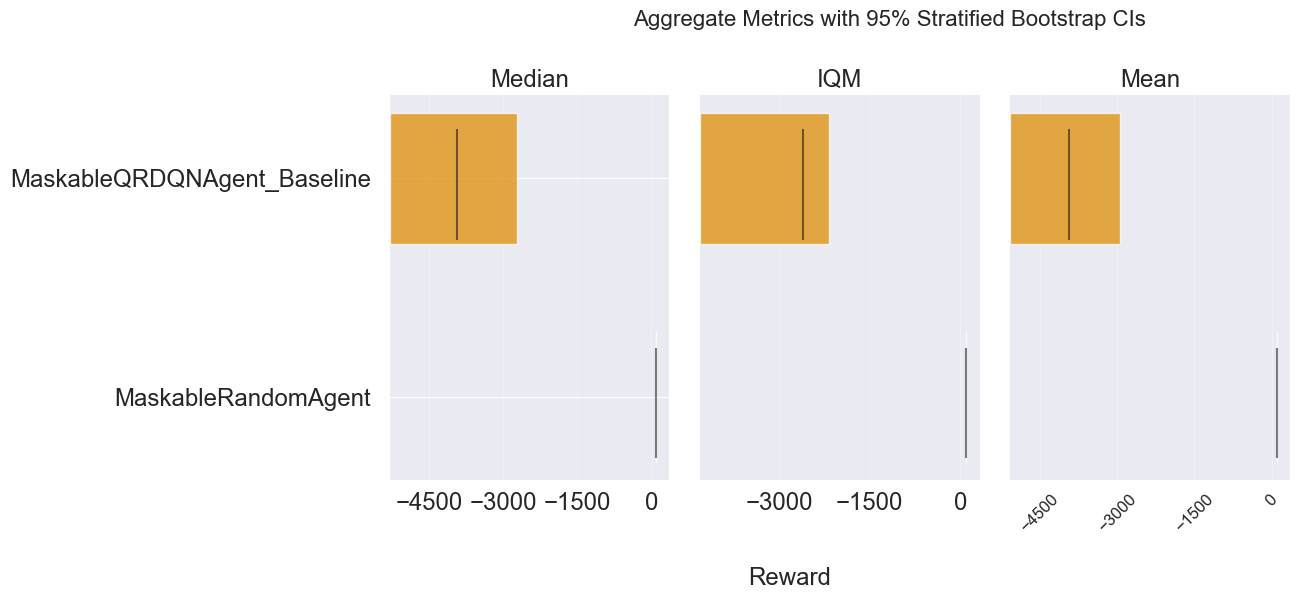

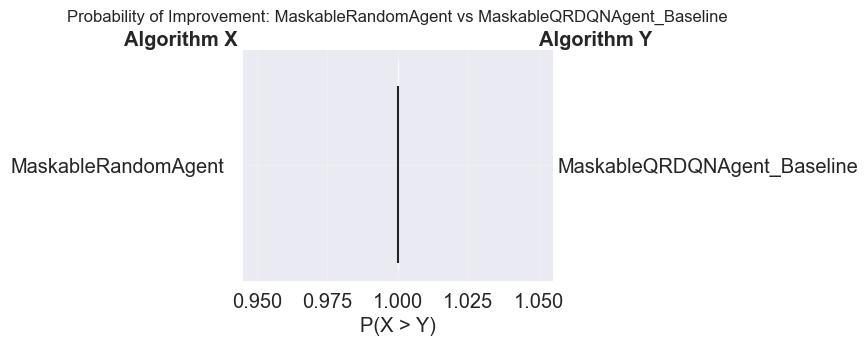

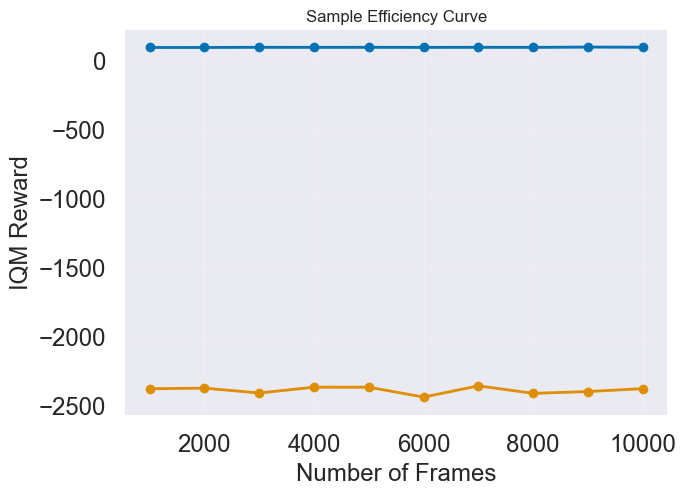

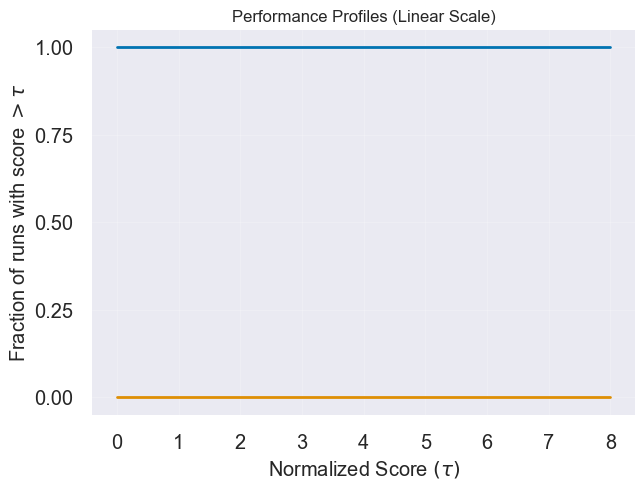

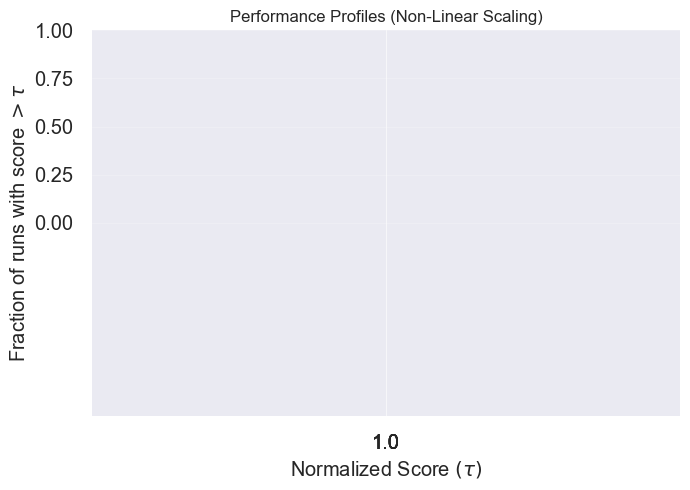

In [ ]:
#| export
plot_evaluation_results(results)

### Evaluation MaskablePPO with default hyperparameters on ElectricityMarketEnv

In [ ]:
#| export
results["MaskablePPOAgent_Baseline"] = maskable_ppo_agent.evaluate_policy(hyperparameters=None, n_episodes=N_EPISODES, render=False)


Running experiment with seed 123456...

Collected Rewards (shape: seeds x checkpoints x episodes):
 [[[ 69.747563  66.046189  65.333848  67.867406  73.296267  69.491343
    71.85997   72.23696   64.172954  65.354585]
  [ 86.544067  81.448046  80.198392  85.546568  81.298916  84.637882
    80.758333  85.015632  93.021001  73.692673]
  [112.5555   115.833892 105.423585 105.567115 107.318034 110.68442
   104.813983 105.266504 105.03192  104.449381]
  [112.052534 118.858567 121.808215 117.114974 116.127342 122.152613
   111.492349 117.233535 118.753679 113.512288]
  [137.327404 140.543521 129.45288  139.240066 128.764532 131.00567
   131.184359 129.434224 134.889538 135.467852]
  [142.334508 141.801799 139.312004 143.941967 146.943984 145.833546
   145.001862 145.857605 148.259978 140.700494]
  [135.495932 137.918245 138.329562 142.351918 140.981913 136.422207
   130.539962 133.323572 134.158519 137.723315]
  [214.315722 215.480754 204.988032 212.945798 205.817298 207.540725
   207.555326

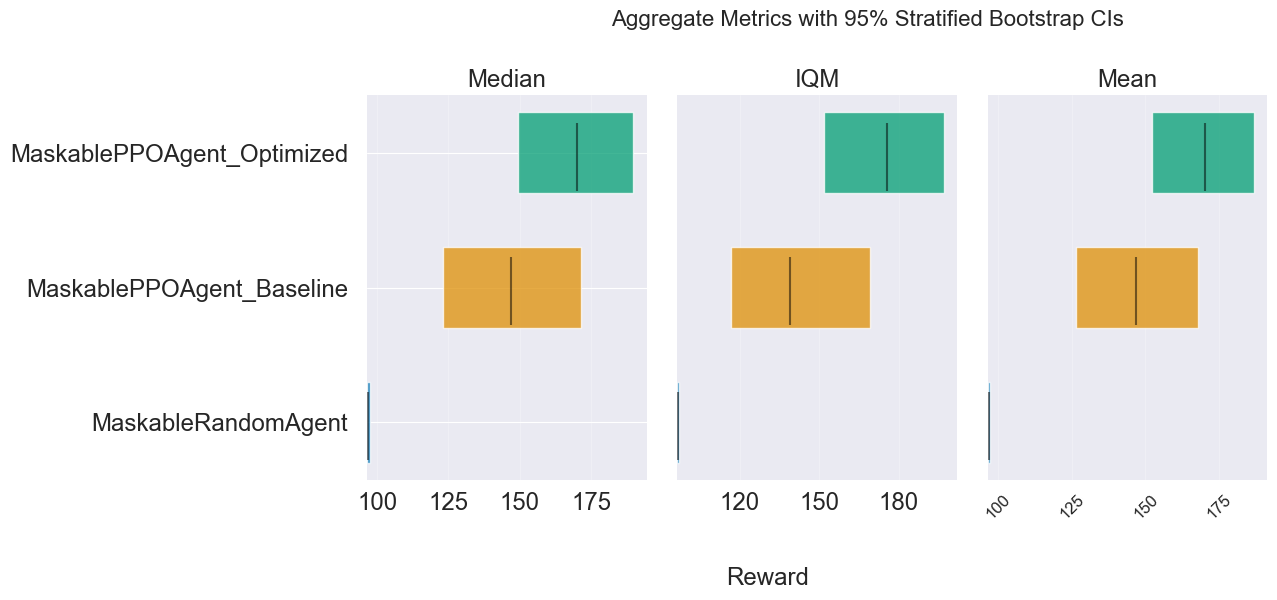

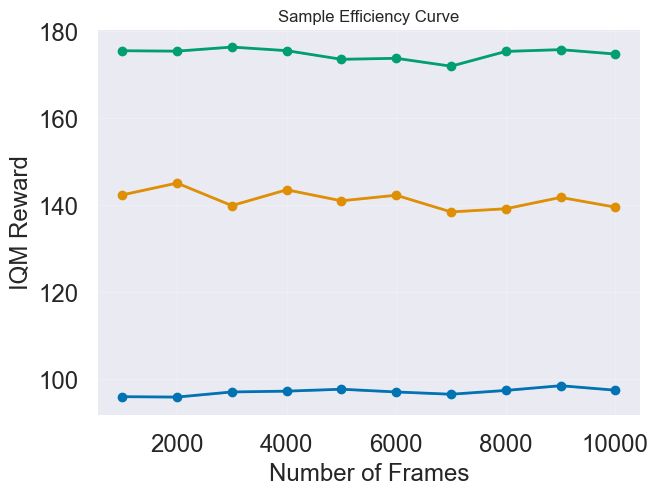

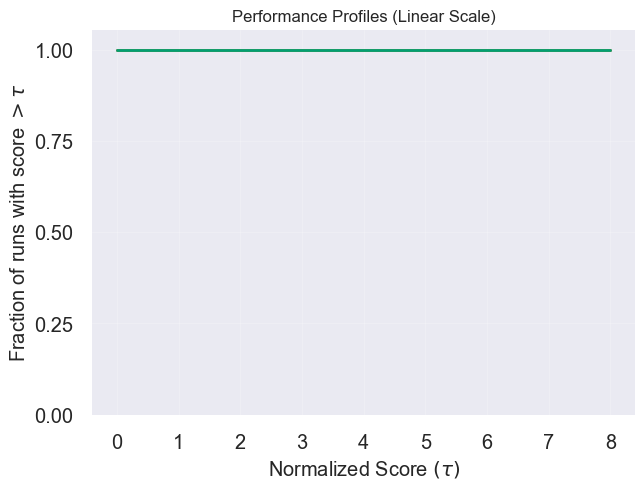

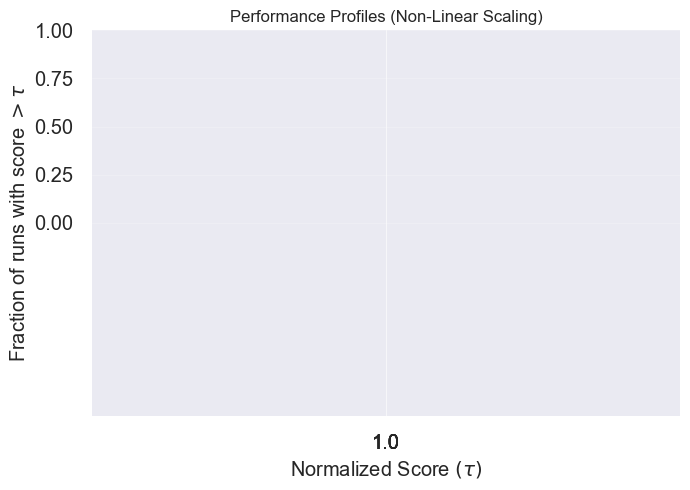

In [ ]:
#| export
plot_evaluation_results(results)

### Hypertuning MaskablePPO with default hyperparameters on ElectricityMarketEnv

In [ ]:
#| export
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(maskable_ppo_agent.optimize_agent, n_trials=N_TRAILS, n_jobs=N_JOBS)

print("Best trial:", study.best_trial)

[I 2025-02-21 19:47:58,158] A new study created in memory with name: no-name-5a227a9b-46bc-47f8-9a22-6db96eef19c7
[I 2025-02-21 19:58:20,077] Trial 1 finished with value: 31.5829788 and parameters: {'learning_rate': 1.826406768447596e-05, 'n_steps': 114, 'batch_size': 140, 'gamma': 0.9752163934748276, 'gae_lambda': 0.9209203270598906, 'ent_coef': 0.007656402974041848, 'vf_coef': 0.2938483660454405, 'clip_range': 0.15176958351399372, 'max_grad_norm': 0.36665002809946756}. Best is trial 1 with value: 31.5829788.
[I 2025-02-21 19:58:32,110] Trial 0 finished with value: 88.5763258 and parameters: {'learning_rate': 0.00017536357399480345, 'n_steps': 70, 'batch_size': 219, 'gamma': 0.9147164308871829, 'gae_lambda': 0.8698250414534332, 'ent_coef': 0.003911262072842044, 'vf_coef': 0.84857675465354, 'clip_range': 0.13343063925667878, 'max_grad_norm': 0.34535858848168227}. Best is trial 0 with value: 88.5763258.
[I 2025-02-21 19:58:44,522] Trial 6 finished with value: 197.9016548 and parameters:

Best trial: FrozenTrial(number=6, state=1, values=[197.9016548], datetime_start=datetime.datetime(2025, 2, 21, 19, 47, 58, 165439), datetime_complete=datetime.datetime(2025, 2, 21, 19, 58, 44, 522076), params={'learning_rate': 0.0005868858036826903, 'n_steps': 288, 'batch_size': 65, 'gamma': 0.9935745992922074, 'gae_lambda': 0.9510337616316424, 'ent_coef': 0.01259614758592152, 'vf_coef': 0.8811828746933461, 'clip_range': 0.1146121966788528, 'max_grad_norm': 0.8497236489111631}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.001, log=True, low=1e-05, step=None), 'n_steps': IntDistribution(high=1024, log=True, low=32, step=1), 'batch_size': IntDistribution(high=256, log=True, low=16, step=1), 'gamma': FloatDistribution(high=0.9999, log=False, low=0.9, step=None), 'gae_lambda': FloatDistribution(high=1.0, log=False, low=0.8, step=None), 'ent_coef': FloatDistribution(high=0.02, log=False, low=0.0, step=None), 'vf_coef': Floa

### Evaluation MaskablePPO with optimized hyperparameters on ElectricityMarketEnv

In [ ]:
#| export
results["MaskablePPOAgent_Optimized"] = maskable_ppo_agent.evaluate_policy(hyperparameters=study.best_trial.params, n_episodes=N_EPISODES, render=False)


Running experiment with seed 123456...

Collected Rewards (shape: seeds x checkpoints x episodes):
 [[[ 78.140695  75.134262  73.533911  71.627417  77.256409  73.851377
    70.875533  73.855435  73.588356  75.999677]
  [175.761766 175.504783 185.166301 177.919642 188.359487 178.033811
   174.462848 179.107619 174.449093 177.128615]
  [123.106256 125.287449 122.285841 130.05317  116.523371 118.13169
   119.445908 118.770796 125.293391 122.943708]
  [128.339733 130.254567 124.930338 133.100292 117.186424 120.09129
   122.50324  126.328195 118.782907 129.782911]
  [165.873373 172.684966 172.04799  172.466915 161.805247 170.248779
   167.328697 169.271298 171.67705  171.162944]
  [157.159644 149.531508 156.922528 156.899314 154.811822 157.420373
   157.8367   155.73067  158.405282 158.212601]
  [210.603922 212.705328 204.416701 207.393842 206.939404 207.197353
   208.155666 204.162437 208.76213  201.836502]
  [217.184277 223.750233 221.613216 220.163246 219.918866 225.308979
   228.650277

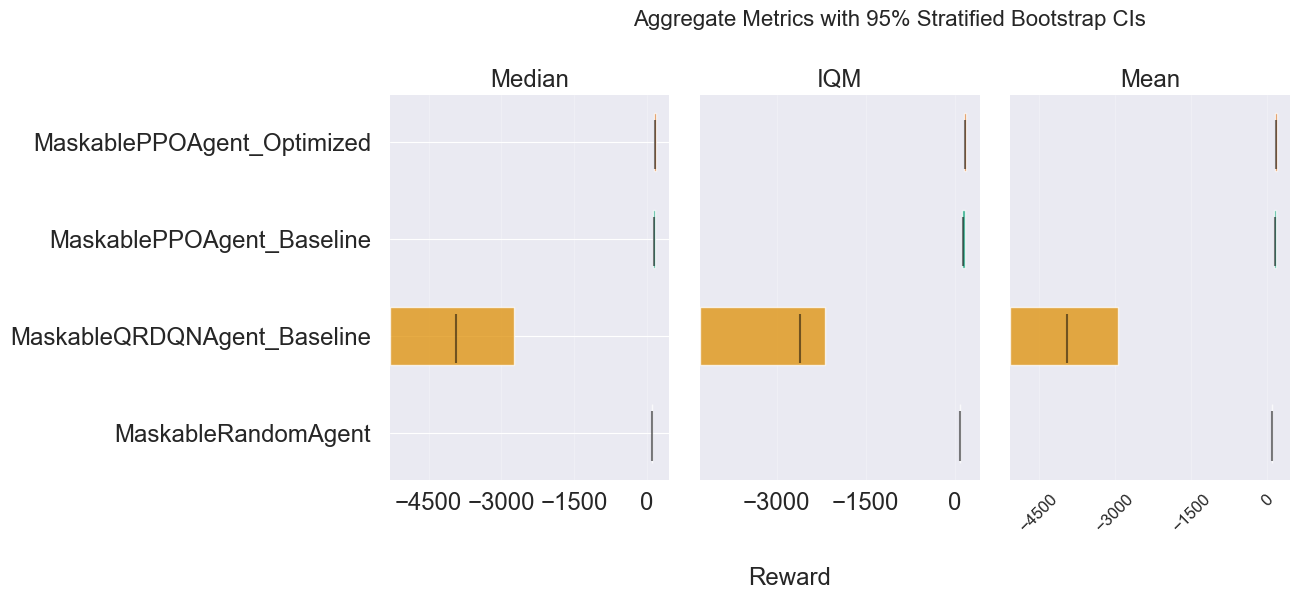

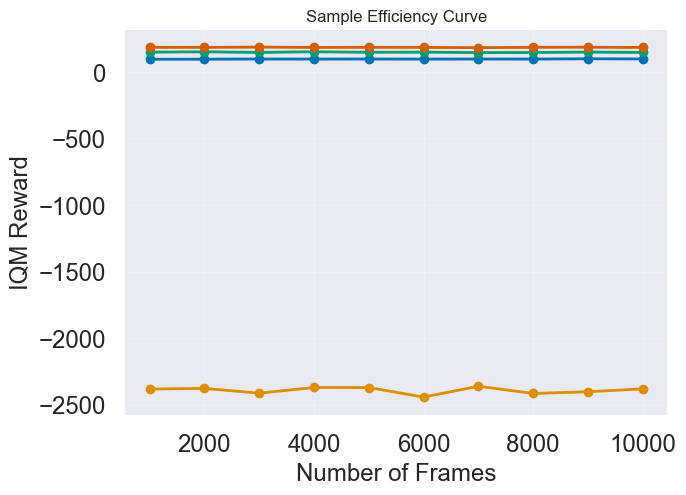

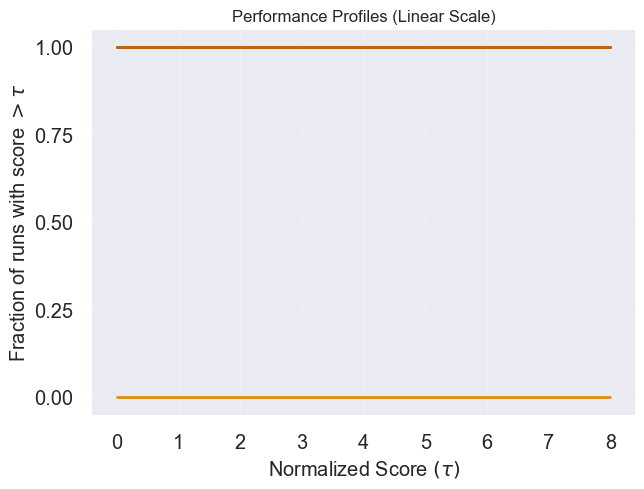

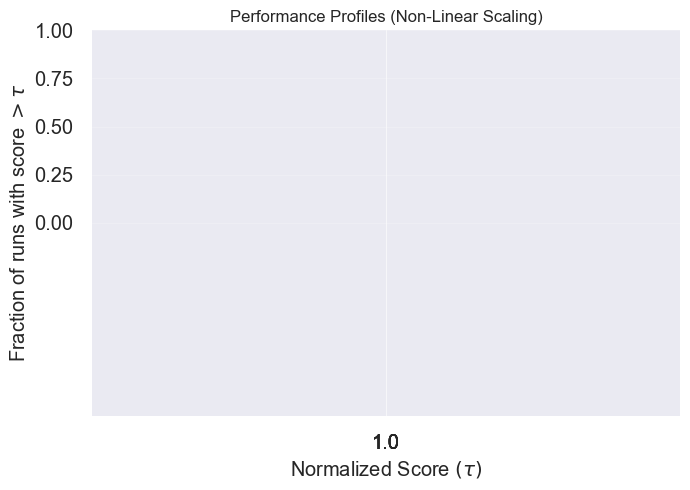

In [ ]:
#| export
plot_evaluation_results(results)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()